# Plot qPCR of RNA export in simple format

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_simple"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_simple_Cq.csv"

cq_raw = pd.read_csv(infile, header=0, index_col=0)

print(cq_raw.shape)
cq_raw.head()

(60, 14)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note
Well,,,,,,,,,,,,,,
A01,SYBR,mCherry,Unkn-01,Well1,NaN,24.090542,23.753076,0.330928,23481.371310,4.370723,29245.117340,5842.094058,67,NaN
A02,SYBR,mCherry,Unkn-02,Well2,NaN,26.551036,26.282249,0.232778,5228.978486,3.718417,6201.748443,842.449381,67,NaN
A03,SYBR,mCherry,Unkn-03,Well3,NaN,23.255805,23.179284,0.161340,39086.082320,4.592022,41090.092920,4149.966455,67,NaN
A04,SYBR,mCherry,Unkn-04,Well4,NaN,32.914710,33.127782,0.229934,107.480635,2.031330,94.986912,13.116390,67,NaN
A05,SYBR,mCherry,Unkn-05,Well5,NaN,25.644092,25.320378,0.316085,9096.169304,3.958859,11220.859620,2139.601335,67,NaN


## Set sample labels and colors

In [5]:
# Set well labels
column_to_xticklabel = {"Well1": "Gag + mCherry-Psi", 
                        "Well2": "Gag + mCherry",
                        "Well3": "Gag-MCP + mCherry-MS2x12", 
                        "Well4": "Gag-MCP + mCherry", 
                        "Well5": "GagZip-MCP + mCherry-MS2x12", 
                        "Well6": "GagZip-MCP + mCherry", 
                        "Well7": "EPN24-MCP + mCherry-MS2x12", 
                        "Well8": "EPN24-MCP + mCherry",
                        "Well9": "mCherry-MS2x12",
                        "Well10": "mCherry-Psi",
                        "Well11": "mCherry",
                        "Well12": "No DNA",
                        "H2O": "No template control"}

In [6]:
# Set exporters
column_to_exporter =   {"Well1": "Gag", 
                        "Well2": "Gag",
                        "Well3": "Gag-MCP", 
                        "Well4": "Gag-MCP", 
                        "Well5": "GagZip-MCP", 
                        "Well6": "GagZip-MCP", 
                        "Well7": "EPN24-MCP", 
                        "Well8": "EPN24-MCP",
                        "Well9": "None",
                        "Well10": "None",
                        "Well11": "None",
                        "Well12": "No DNA",
                        "H2O": "No template control"}

In [7]:
# Set well labels
column_to_reporter = {"Well1": "mCherry-Psi", 
                        "Well2": "mCherry",
                        "Well3": "mCherry-MS2x12", 
                        "Well4": "mCherry", 
                        "Well5": "mCherry-MS2x12", 
                        "Well6": "mCherry", 
                        "Well7": "mCherry-MS2x12", 
                        "Well8": "mCherry",
                        "Well9": "mCherry-MS2x12",
                        "Well10": "mCherry-Psi",
                        "Well11": "mCherry",
                        "Well12": "No DNA",
                        "H2O": "No template control"}

In [8]:
# Set well colors

color_exporter_Gag = "#31a354"
color_exporter_engineered = "#756bb1"
color_no_packaging_signal = "#737373"
color_no_exporter = "#bdbdbd"

column_to_color = {"Well1": color_exporter_Gag,
                   "Well2": color_no_packaging_signal,
                   "Well3": color_exporter_engineered,
                   "Well4": color_no_packaging_signal,
                   "Well5": color_exporter_engineered,
                   "Well6": color_no_packaging_signal,
                   "Well7": color_exporter_engineered,
                   "Well8": color_no_packaging_signal,
                   "Well9": color_no_exporter,
                   "Well10": color_no_exporter,
                   "Well11": color_no_exporter,
                   "Well12": color_no_exporter,
                   "H2O": color_no_packaging_signal}

In [9]:
# Set legend labels
column_to_label = {"Well1": "Both exporter and packaging signal", 
                        "Well2": "No packaging signal",
                        "Well3": "Both exporter and packaging signal", 
                        "Well4": "No packaging signal",
                        "Well5": "Both exporter and packaging signal", 
                        "Well6": "No packaging signal",
                        "Well7": "Both exporter and packaging signal", 
                        "Well8": "No packaging signal",
                        "Well9": "No exporter",
                        "Well10": "No exporter",
                        "Well11": "No exporter",
                        "Well12": "No DNA",
                        "H2O": "No template control"}

# Preprocess data

In [10]:
# Reset index so that well becomes a column
cq_raw.reset_index(inplace=True)

## Calculate total starting molecules

In [11]:
# Calculate normalization for input volume

FRACTION_OF_SUPERNATANT_SAMPLED = (140/1000) * (20/42) * (10/61) * (1/20)  # Fraction of total supernatant volume that was input to qPCR

print("Fraction of supernatant sampled:", FRACTION_OF_SUPERNATANT_SAMPLED)

Fraction of supernatant sampled: 0.0005464480874316939


In [12]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [13]:
# Calculate input RNA molecules
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED) * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED) * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED) * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [14]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
H2O,48.288100,NaN,1.483214e+07,0.000000e+00
Well1,29245.117337,5842.094061,8.982910e+09,1.794453e+09
Well10,88.708070,50.578201,2.724751e+07,1.553556e+07
Well11,52.597185,6.720080,1.615571e+07,2.064135e+06
Well12,NaN,NaN,NaN,0.000000e+00
Well2,6201.748443,842.449381,1.904925e+09,2.587662e+08
Well3,41090.092920,4149.966458,1.262120e+10,1.274701e+09
Well4,94.986912,13.116390,2.917611e+07,4.028821e+06
Well5,11220.859618,2139.601336,3.446591e+09,6.571984e+08


## Censor results by limit of detection

To calculate lower limit of quantification (signal in the absence of template), we note that 5/6 NTC wells and 3/3 No DNA wells were below threshold, leaving 1/6 NTC well that surpassed the threshold. To obtain a conservative limit of detection, we use the positive NTC well's threshold value.

In [15]:
# Conservative limit of detection (1/6 H2O well came up above threshold and we use that value)

# Report limit of detection (background in no template control)
LOD = summary.loc["H2O", "RNA molecules"]
print("Limit of detection:", LOD)

Limit of detection: 14832138.490283666


In [16]:
# Substitute LOD for values below LOD
cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

In [17]:
# Substitute LOD for values below LOD
summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

# Visualize RNA export as simple line and swarm plots

## Set plot parameters

In [18]:
# Set plot parameters
figsize = (1.25, 0.8)

ypos_text_exporter = -0.15
ypos_text_export_tag = -0.35

## Gag

In [19]:
# Choose samples
columns_ordered = ["Well1", "Well2", "Well10", "Well11"]

In [20]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(4, 6)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,label
Sample,,,,,,
Well1,29245.117337,5842.094061,8.982910e+09,1.794453e+09,8.982910e+09,Both exporter and packaging signal
Well2,6201.748443,842.449381,1.904925e+09,2.587662e+08,1.904925e+09,No packaging signal
Well10,88.708070,50.578201,2.724751e+07,1.553556e+07,2.724751e+07,No exporter
Well11,52.597185,6.720080,1.615571e+07,2.064135e+06,1.615571e+07,No exporter


In [21]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(columns_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 19)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
0,A01,SYBR,mCherry,Unkn-01,Well1,NaN,24.090542,23.753076,0.330928,23481.371310,4.370723,29245.117340,5842.094058,67,NaN,7.212521e+09,8.982910e+09,1.794453e+09,7.212521e+09
1,A02,SYBR,mCherry,Unkn-02,Well2,NaN,26.551036,26.282249,0.232778,5228.978486,3.718417,6201.748443,842.449381,67,NaN,1.606129e+09,1.904925e+09,2.587662e+08,1.606129e+09
9,A10,SYBR,mCherry,Unkn-10,Well10,NaN,34.121737,33.395551,0.885023,51.443781,1.711333,88.708070,50.578201,67,NaN,1.580144e+07,2.724751e+07,1.553556e+07,1.580144e+07
10,A11,SYBR,mCherry,Unkn-11,Well11,NaN,34.133922,34.094151,0.206149,51.062558,1.708103,52.597185,6.720080,67,NaN,1.568434e+07,1.615571e+07,2.064135e+06,1.568434e+07
12,B01,SYBR,mCherry,Unkn-01,Well1,NaN,23.739588,23.753076,0.330928,29091.453030,4.463765,29245.117340,5842.094058,67,NaN,8.935710e+09,8.982910e+09,1.794453e+09,8.935710e+09


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


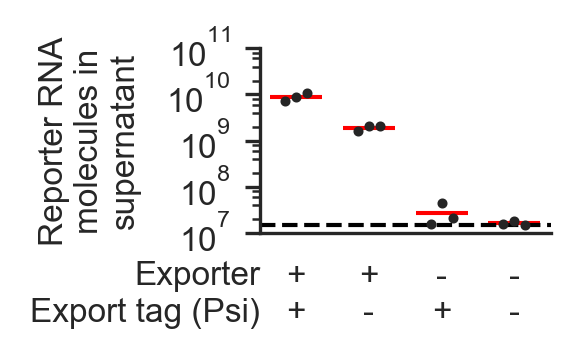

In [22]:
# Make simple swarm plot

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e7, 1e11)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(x=x, y=y, ax=ax, marker="_", s=150, color="r")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=6)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["+\n+", "+\n-", "-\n+", "-\n-"]
ax.set_xticklabels(xticklabels)

ax.text(0, ypos_text_exporter, "Exporter", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)
ax.text(0, ypos_text_export_tag, "Export tag (Psi)", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)

# Draw line indicating limit of detection
ax.axhline(LOD, ls="--", color="k", lw=1)

ax.tick_params(axis='x', which='both', bottom=False)  # remove xticks
sns.despine()

save_figure(fig, "line_swarm_Gag")

In [23]:
# Report statistics
print("Export efficiency for target RNA:", summary_subset.loc["Well1", "RNA molecules censored"] / summary_subset.loc["Well10", "RNA molecules censored"])
print("Export efficiency for non-target RNA:", summary_subset.loc["Well2", "RNA molecules censored"] / summary_subset.loc["Well11", "RNA molecules censored"])
print("Export specificity ratio:", summary_subset.loc["Well1", "RNA molecules censored"] / summary_subset.loc["Well2", "RNA molecules censored"])

Export efficiency for target RNA: 329.67820488288913
Export efficiency for non-target RNA: 117.91027375267502
Export specificity ratio: 4.715624570559277


## Gag-MCP

In [24]:
# Choose samples
columns_ordered = ["Well3", "Well4", "Well9", "Well11"]

In [25]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(4, 6)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,label
Sample,,,,,,
Well3,41090.092920,4149.966458,1.262120e+10,1.274701e+09,1.262120e+10,Both exporter and packaging signal
Well4,94.986912,13.116390,2.917611e+07,4.028821e+06,2.917611e+07,No packaging signal
Well9,31.159003,15.035318,9.570777e+06,4.618238e+06,1.483214e+07,No exporter
Well11,52.597185,6.720080,1.615571e+07,2.064135e+06,1.615571e+07,No exporter


In [26]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(columns_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 19)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
2,A03,SYBR,mCherry,Unkn-03,Well3,NaN,23.255805,23.179284,0.161340,39086.082320,4.592022,41090.092920,4149.966455,67,NaN,1.200565e+10,1.262120e+10,1.274701e+09,1.200565e+10
3,A04,SYBR,mCherry,Unkn-04,Well4,NaN,32.914710,33.127782,0.229934,107.480635,2.031330,94.986912,13.116390,67,NaN,3.301368e+07,2.917611e+07,4.028821e+06,3.301368e+07
8,A09,SYBR,mCherry,Unkn-09,Well9,NaN,34.545439,35.119495,1.002840,39.719561,1.599004,31.159003,15.035318,67,NaN,1.220023e+07,9.570777e+06,4.618238e+06,1.483214e+07
10,A11,SYBR,mCherry,Unkn-11,Well11,NaN,34.133922,34.094151,0.206149,51.062558,1.708103,52.597185,6.720080,67,NaN,1.568434e+07,1.615571e+07,2.064135e+06,1.568434e+07
14,B03,SYBR,mCherry,Unkn-03,Well3,NaN,22.993922,23.179284,0.161340,45861.737160,4.661451,41090.092920,4149.966455,67,NaN,1.408686e+10,1.262120e+10,1.274701e+09,1.408686e+10


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


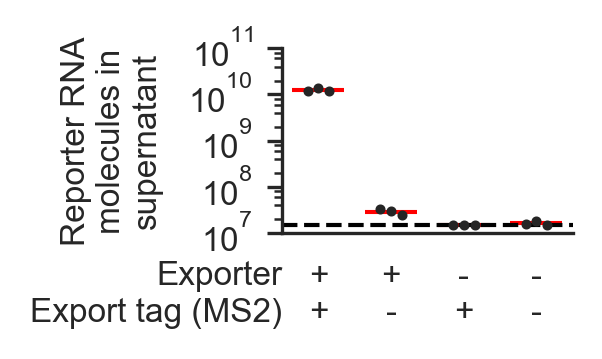

In [27]:
# Make simple swarm plot

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e7, 1e11)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(x=x, y=y, ax=ax, marker="_", s=150, color="r")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=6)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["+\n+", "+\n-", "-\n+", "-\n-"]
ax.set_xticklabels(xticklabels)

ax.text(0, ypos_text_exporter, "Exporter", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)
ax.text(0, ypos_text_export_tag, "Export tag (MS2)", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)

# Draw line indicating limit of detection
ax.axhline(LOD, ls="--", color="k", lw=1)

ax.tick_params(axis='x', which='both', bottom=False)  # remove xticks
sns.despine()

save_figure(fig, "line_swarm_GagMCP")

In [28]:
# Report statistics
print("Export efficiency for target RNA:", summary_subset.loc["Well3", "RNA molecules censored"] / summary_subset.loc["Well9", "RNA molecules censored"])
print("Export efficiency for non-target RNA:", summary_subset.loc["Well4", "RNA molecules censored"] / summary_subset.loc["Well11", "RNA molecules censored"])
print("Export specificity ratio:", summary_subset.loc["Well3", "RNA molecules censored"] / summary_subset.loc["Well4", "RNA molecules censored"])

Export efficiency for target RNA: 850.9362193141814
Export efficiency for non-target RNA: 1.8059314805911602
Export specificity ratio: 432.5868926203907


## GagZip-MCP

In [29]:
# Choose samples
columns_ordered = ["Well5", "Well6", "Well9", "Well11"]

In [30]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(4, 6)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,label
Sample,,,,,,
Well5,11220.859618,2139.601336,3.446591e+09,6.571984e+08,3.446591e+09,Both exporter and packaging signal
Well6,38.934776,14.524585,1.195918e+07,4.461361e+06,1.483214e+07,No packaging signal
Well9,31.159003,15.035318,9.570777e+06,4.618238e+06,1.483214e+07,No exporter
Well11,52.597185,6.720080,1.615571e+07,2.064135e+06,1.615571e+07,No exporter


In [31]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(columns_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 19)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
4,A05,SYBR,mCherry,Unkn-05,Well5,NaN,25.644092,25.320378,0.316085,9096.169304,3.958859,11220.859620,2139.601335,67,NaN,2.793973e+09,3.446591e+09,6.571984e+08,2.793973e+09
5,A06,SYBR,mCherry,Unkn-06,Well6,NaN,35.428327,34.666355,0.682480,23.170757,1.364940,38.934776,14.524585,67,NaN,7.117113e+06,1.195918e+07,4.461361e+06,1.483214e+07
8,A09,SYBR,mCherry,Unkn-09,Well9,NaN,34.545439,35.119495,1.002840,39.719561,1.599004,31.159003,15.035318,67,NaN,1.220023e+07,9.570777e+06,4.618238e+06,1.483214e+07
10,A11,SYBR,mCherry,Unkn-11,Well11,NaN,34.133922,34.094151,0.206149,51.062558,1.708103,52.597185,6.720080,67,NaN,1.568434e+07,1.615571e+07,2.064135e+06,1.568434e+07
16,B05,SYBR,mCherry,Unkn-05,Well5,NaN,25.304524,25.320378,0.316085,11191.342980,4.048882,11220.859620,2139.601335,67,NaN,3.437525e+09,3.446591e+09,6.571984e+08,3.437525e+09


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


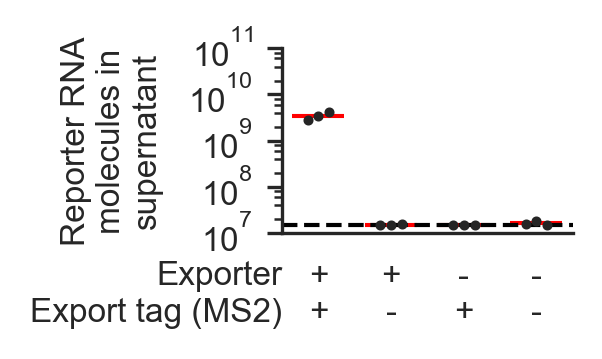

In [32]:
# Make simple swarm plot

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e7, 1e11)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(x=x, y=y, ax=ax, marker="_", s=150, color="r")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=6)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["+\n+", "+\n-", "-\n+", "-\n-"]
ax.set_xticklabels(xticklabels)

ax.text(0, ypos_text_exporter, "Exporter", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)
ax.text(0, ypos_text_export_tag, "Export tag (MS2)", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)

# Draw line indicating limit of detection
ax.axhline(LOD, ls="--", color="k", lw=1)

ax.tick_params(axis='x', which='both', bottom=False)  # remove xticks
sns.despine()

save_figure(fig, "line_swarm_GagZipMCP")

In [33]:
# Report statistics
print("Export efficiency for target RNA:", summary_subset.loc["Well5", "RNA molecules censored"] / summary_subset.loc["Well9", "RNA molecules censored"])
print("Export efficiency for non-target RNA:", summary_subset.loc["Well6", "RNA molecules censored"] / summary_subset.loc["Well11", "RNA molecules censored"])
print("Export specificity ratio:", summary_subset.loc["Well5", "RNA molecules censored"] / summary_subset.loc["Well6", "RNA molecules censored"])

Export efficiency for target RNA: 232.3731873613901
Export efficiency for non-target RNA: 0.9180738458916504
Export specificity ratio: 232.3731873613901


## EPN24-MCP

In [34]:
# Choose samples
columns_ordered = ["Well7", "Well8", "Well9", "Well11"]

In [35]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[columns_ordered]

# Set label
summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(4, 6)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,label
Sample,,,,,,
Well7,75178.828547,10298.581381,2.309188e+10,3.163305e+09,2.309188e+10,Both exporter and packaging signal
Well8,774.738379,31.992493,2.379681e+08,9.826791e+06,2.379681e+08,No packaging signal
Well9,31.159003,15.035318,9.570777e+06,4.618238e+06,1.483214e+07,No exporter
Well11,52.597185,6.720080,1.615571e+07,2.064135e+06,1.615571e+07,No exporter


In [36]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(columns_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 19)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
6,A07,SYBR,mCherry,Unkn-07,Well7,NaN,22.465453,22.195164,0.234618,63321.895610,4.801554,75178.828550,10298.581380,67,NaN,1.944991e+10,2.309188e+10,3.163305e+09,1.944991e+10
7,A08,SYBR,mCherry,Unkn-08,Well8,NaN,29.723983,29.679921,0.066902,753.755273,2.877230,774.738379,31.992492,67,NaN,2.315229e+08,2.379681e+08,9.826791e+06,2.315229e+08
8,A09,SYBR,mCherry,Unkn-09,Well9,NaN,34.545439,35.119495,1.002840,39.719561,1.599004,31.159003,15.035318,67,NaN,1.220023e+07,9.570777e+06,4.618238e+06,1.483214e+07
10,A11,SYBR,mCherry,Unkn-11,Well11,NaN,34.133922,34.094151,0.206149,51.062558,1.708103,52.597185,6.720080,67,NaN,1.568434e+07,1.615571e+07,2.064135e+06,1.568434e+07
18,B07,SYBR,mCherry,Unkn-07,Well7,NaN,22.044107,22.195164,0.234618,81895.098590,4.913258,75178.828550,10298.581380,67,NaN,2.515484e+10,2.309188e+10,3.163305e+09,2.515484e+10


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


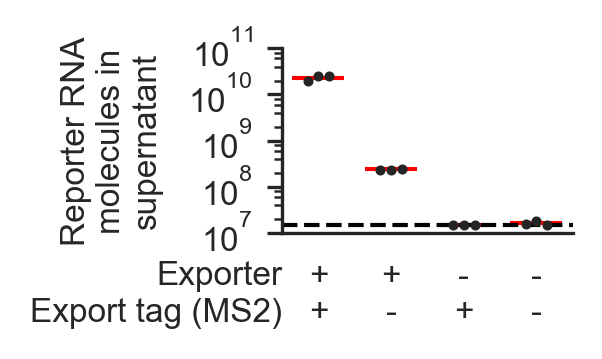

In [37]:
# Make simple swarm plot

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_yscale("log")
ax.set_ylim(1e7, 1e11)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(x=x, y=y, ax=ax, marker="_", s=150, color="r")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(columns_ordered, range(len(columns_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant", labelpad=6)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["+\n+", "+\n-", "-\n+", "-\n-"]
ax.set_xticklabels(xticklabels)

ax.text(0, ypos_text_exporter, "Exporter", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)
ax.text(0, ypos_text_export_tag, "Export tag (MS2)", transform=ax.transAxes, ha="right", va="top", size=FONTSIZE)

# Draw line indicating limit of detection
ax.axhline(LOD, ls="--", color="k", lw=1)

ax.tick_params(axis='x', which='both', bottom=False)  # remove xticks
sns.despine()

save_figure(fig, "line_swarm_EPN24MCP")

In [38]:
# Report statistics
print("Export efficiency for target RNA:", summary_subset.loc["Well7", "RNA molecules censored"] / summary_subset.loc["Well9", "RNA molecules censored"])
print("Export efficiency for non-target RNA:", summary_subset.loc["Well8", "RNA molecules censored"] / summary_subset.loc["Well11", "RNA molecules censored"])
print("Export specificity ratio:", summary_subset.loc["Well7", "RNA molecules censored"] / summary_subset.loc["Well8", "RNA molecules censored"])

Export efficiency for target RNA: 1556.881077405205
Export efficiency for non-target RNA: 14.729654904089479
Export specificity ratio: 97.03769759958865
